In [1]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt

## Modelos de Difusión.
Basados en eliminar ruido de una imágen.
Si se alimentan con ruido aleatgorio, genera imágenes nuevas.

Su principal fortaleza es el Refinamiento iterativo

In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256", use_safetensors=False).to("cuda")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

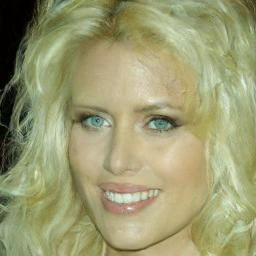

In [3]:
image_pipe().images[0]

## Vistazo más profundo
Usando un pipeline ya creado no permite conocer bien el funcionamiento del modelo
¡Hagamos una prueba a mano!

In [4]:
## Generación basada en distribución Normal. Si no, falla a la hora de generar las imágenes.
image = torch.randn(4,3,256,256).cuda()  # Lote de 4 imágenes de 3 canales de 256x256 px

# Especificamos el numero de iteraciones de la generación:
image_pipe.scheduler.set_timesteps(num_inference_steps=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.282073..4.6835203].


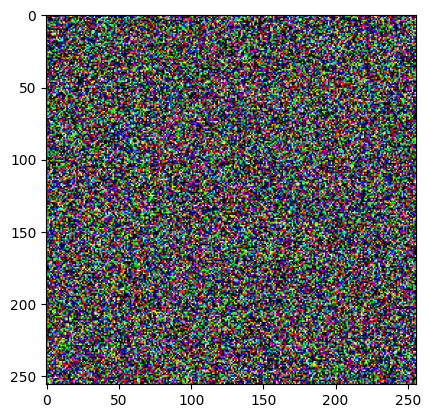

In [5]:
plt.imshow(image.cpu()[0].movedim(0,-1));   #Mostramos la imagen aleatoria generada.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.154331..4.6842327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0


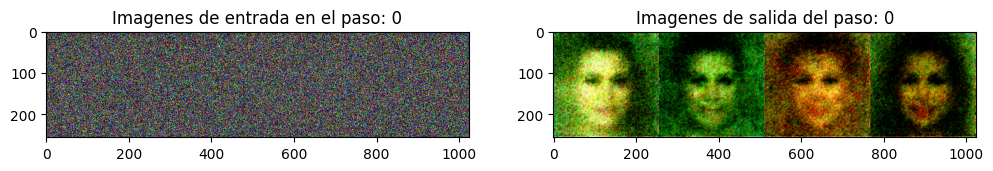

10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.600364..4.615061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.93786764].


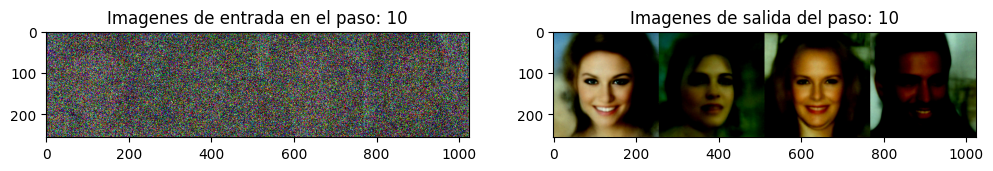

20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6716886..3.341906].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9882635..1.0].


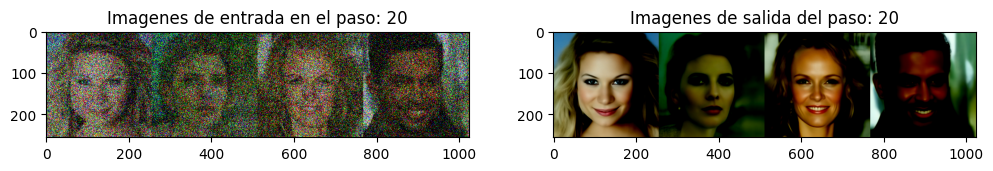

29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99630755..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99630755..1.0].


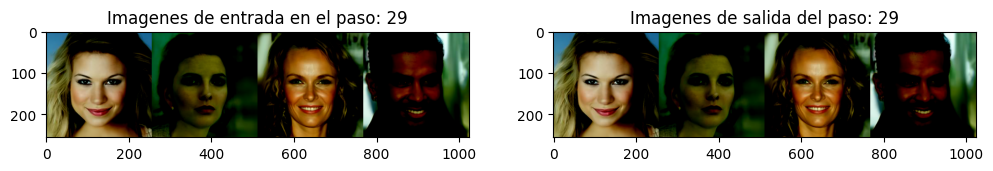

In [6]:
# Bucle de generación
for i, t in enumerate(image_pipe.scheduler.timesteps):

    with torch.inference_mode():                        # Iteramos una vez. No estamos entrenando, por lo que usamos el modo inferencia.
        noise_pred = image_pipe.unet(image,t)["sample"]

    # Calculamos la actualización de nuestras muestras aleatorias
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, image)

    # volvemos a utilizar los datos como generados como entrada de la red
    image = scheduler_output.prev_sample

    # Mostramos los resultados.
    if (i%10 == 0) or (i == len(image_pipe.scheduler.timesteps)-1):
        # img_list = [torch.Tensor(normalizar_a_255_general(x.cpu().numpy())).int() for x in scheduler_output.prev_sample] + [torch.Tensor(normalizar_a_255_general(x.cpu().numpy())).int() for x in scheduler_output.pred_original_sample]
        img_list = [x for x in scheduler_output.prev_sample]
        generation_list = [x for x in scheduler_output.pred_original_sample]

        full_img = torch.cat(img_list,dim=2)
        full_generation = torch.cat(generation_list, dim=2)

        plt.subplots(1,2,figsize=(12,4))
        print(i)
        
        plt.subplot(1,2,1)
        plt.title("Imagenes de entrada en el paso: "+str(i))
        plt.imshow(full_img.cpu().movedim(0,-1));

        plt.subplot(1,2,2)
        plt.title("Imagenes de salida del paso: "+str(i))
        plt.imshow(full_generation.cpu().movedim(0,-1));

        plt.pause(0.1)

